### base test

In [1]:
item = 'field_best_z0'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.io as scio
import torch
import torch.nn as nn
from torchinfo import summary
from timeit import default_timer
import sys
sys.path.append("../scripts/")
sys.path.append("../run/")
import yaml
from utilities import *
from deeponet_field_2d import *
# from fourier_2d import *
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

ModuleNotFoundError: No module named 'deeponet_field_2d'

In [ ]:
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize']  = 7 # x, y label size
plt.rcParams['axes.titlesize'] = 7 # font size of the axes title
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

cm = 1/2.54

In [ ]:
with open( '../run/config_field.yml') as f:
    config = yaml.full_load(f)
config = config[item]
device = torch.device('cpu')
TRAIN_PATH = config['TRAIN_PATH']
TEST_PATH  = config['TEST_PATH']
save_mode  = config['save_mode']
n_out      = config['n_out'] # rhoxy,phsxy,rhoyx,phsyx
model_path = "../model/"+config['name']+ "_"+str(n_out) # save path and name of model
model_path_temp = "../temp/"+config['name']+"_"+ str(n_out)
log_path = "../Log/"+config['name']+"_"+str(n_out)+'.log'

ntrain = config['ntrain']
ntest  = config['ntest']

batch_size = config['batch_size']
learning_rate = config['learning_rate']

epochs = config['epochs']
step_size = config['step_size']
gamma = config['gamma']

modes = config['modes']
width = config['width']

s_train = config['s_train']
r_train = config['r_train']
s_test = config['s_test']
r_test = config['r_test']
layer_num = config['layer_num']
last_size = config['last_size'] 
act_fno   = config['act_fno']

layer_sizes = config['layer_sizes']+[s_train[0]*s_train[1]]
act_func  = config['act_func']
init_func = config['init_func']
    

patience = config['patience'] # if there is {patience} epoch that val_error is larger, early stop,
thre_epoch = config['thre_epoch']# condiser early stop after {thre_epoch} epochs

print_model_flag = config['print_model_flag'] # 

In [5]:
loc_train,loc_test,train_loader, test_loader, x_normalizer,y_normalizer = \
get_batch_data(TRAIN_PATH, TEST_PATH, ntrain, ntest, r_train, s_train,r_test, s_test,batch_size,n_out)
data   = scio.loadmat(TEST_PATH)
zn     = data['zn'][0][::r_test[0]][:s_test[0]+1]
yn     = data['yn'][0][::r_test[1]][:s_test[1]+1]
freq   = data['freq'][0][::r_test[2]][:s_test[2]]
ry     = data['obs'][0][::r_test[3]][:s_test[3]]

begin to read data
reading finished in 16.766 s


In [6]:
if os.path.exists(model_path+'.pt'):
    model=torch.load(model_path+'.pt',map_location=device)
elif os.path.exists(model_path+'.pkl'):
    model=deeponet(layer_sizes, act_func, init_func,modes, modes, width,\
        n_out*2,layer_num, last_size, act_fno).to(device)
    model.load_state_dict(torch.load(model_path+'.pkl',map_location=device))
else:
    raise RuntimeError('no model file')
myloss = LpLoss_out(size_average=False)

In [10]:
II = complex(0,1)
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
test_l2_rho = 0.0
# sample = next(iter(test_loader))
t1 = default_timer()
loc_test = loc_test.to(device)

ny = s_test[2]
freq0=10**(loc_test[:,0:1].unique_consecutive())
freq_torch = freq0[None,:,None].repeat(batch_size,1,ny)

with torch.no_grad():
    for x, y in test_loader:
        
        x, y = x.to(device), y.to(device)
        out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
        input_size = s_test[2]*s_test[3]
        n_out = y.shape[-1]
        out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
                for i in range(n_out)]),-1)
        out = y_normalizer.decode(out)
        
        data_EH = [(10**out[...,i*2])*(torch.sin(out[...,i*2+1])+II*torch.cos(out[...,i*2+1])) for i in range(int(n_out/2))]
        out_EH = torch.stack(data_EH,axis=-1)
        y_EH = [(10**y[...,i*2])*(torch.sin(y[...,i*2+1])+II*torch.cos(y[...,i*2+1])) for i in range(int(n_out/2))]
        y_EH = torch.stack(y_EH,axis=-1)
        Hx     = torch.ones_like(out_EH[...,2]) + II * torch.zeros_like(out_EH[...,2])
        rhoxy,phsxy = mt2d_Z(freq_torch,out_EH[...,0],out_EH[...,1])
        rhoyx,phsyx = mt2d_Z(freq_torch,out_EH[...,2],Hx)
        rhoxy_true,phsxy_true = mt2d_Z(freq_torch,y_EH[...,0],y_EH[...,1])
        rhoyx_true,phsyx_true = mt2d_Z(freq_torch,y_EH[...,2],Hx)
        out_rho = torch.stack([torch.log10(rhoxy),phsxy,torch.log10(rhoyx),phsyx],axis=-1)
        out_rho_true = torch.stack([torch.log10(rhoxy_true),phsxy_true,torch.log10(rhoyx_true),phsyx_true],axis=-1)
        
        test_l2 += myloss(out, y)
        test_l2_rho += myloss(out_rho, out_rho_true)
        

test_l20 = test_l2/ntest
test_l2_rho0 = test_l2_rho/ntest

t2 = default_timer()
print(t2-t1, test_l20, test_l2_rho0)

37.03274517785758 tensor([  5.4899,  20.5978,   7.3937, 116.0627,   9.5065,  29.4902]) tensor([13.0748, 19.9566, 20.2590,  9.7198])


In [11]:
print(t2-t1, test_l20, test_l2_rho0)

37.03274517785758 tensor([0.0018, 0.0069, 0.0025, 0.0387, 0.0032, 0.0098]) tensor([0.0044, 0.0067, 0.0068, 0.0032])


In [9]:
II = complex(0,1)
sample = next(iter(test_loader))
t1 = default_timer()
model.eval()
model.to(device)
y_normalizer.to(device)
test_l2 = 0.0
test_l2_rho = 0.0
# sample = next(iter(test_loader))
loc_test = loc_test.to(device)

ny = s_test[2]
freq0=10**(loc_test[:,0:1].unique_consecutive())
freq_torch = freq0[None,:,None].repeat(batch_size,1,ny)
with torch.no_grad():
    x, y = sample[0].to(device), sample[1].to(device)
    out = model(loc_test,x)#.reshape(batch_size, s[2],s[3],-1)
    input_size = s_test[2]*s_test[3]
    n_out = y.shape[-1]
    out = torch.cat(([out[:,i*input_size:(i+1)*input_size].reshape(batch_size,s_test[2],s_test[3],-1) \
            for i in range(n_out)]),-1)
    out = y_normalizer.decode(out)

    data_EH = [(10**out[...,i*2])*(torch.sin(out[...,i*2+1])+II*torch.cos(out[...,i*2+1])) for i in range(int(n_out/2))]
    out_EH = torch.stack(data_EH,axis=-1)
    y_EH = [(10**y[...,i*2])*(torch.sin(y[...,i*2+1])+II*torch.cos(y[...,i*2+1])) for i in range(int(n_out/2))]
    y_EH = torch.stack(y_EH,axis=-1)
    Hx     = torch.ones_like(out_EH[...,2]) + II * torch.zeros_like(out_EH[...,2])
    rhoxy,phsxy = mt2d_Z(freq_torch,out_EH[...,0],out_EH[...,1])
    rhoyx,phsyx = mt2d_Z(freq_torch,out_EH[...,2],Hx)
    rhoxy_true,phsxy_true = mt2d_Z(freq_torch,y_EH[...,0],y_EH[...,1])
    rhoyx_true,phsyx_true = mt2d_Z(freq_torch,y_EH[...,2],Hx)
    out_rho = torch.stack([torch.log10(rhoxy),phsxy,torch.log10(rhoyx),phsyx],axis=-1)
    out_rho_true = torch.stack([torch.log10(rhoxy_true),phsxy_true,torch.log10(rhoyx_true),phsyx_true],axis=-1)

    test_l2 += myloss(out, y)
    test_l2_rho += myloss(out_rho, out_rho_true)





test_l20 = test_l2/ntest
test_l2_rho0 = test_l2_rho/ntest

t2 = default_timer()
print(t2-t1, test_l20, test_l2_rho0)

0.681958207860589 tensor([3.0254e-05, 1.1444e-04, 4.0957e-05, 6.4538e-04, 5.0769e-05, 1.6868e-04]) tensor([7.6917e-05, 1.1166e-04, 1.1591e-04, 5.5920e-05])


In [18]:
out_rho.shape

torch.Size([50, 64, 64, 4])

In [43]:
rho_id=17
Ex_real = out_EH[rho_id, ...,0].real.cpu().numpy()
Ex_imag = out_EH[rho_id, ...,0].imag.cpu().numpy()
Hy_real = out_EH[rho_id, ...,1].real.cpu().numpy()
Hy_imag = out_EH[rho_id, ...,1].imag.cpu().numpy()
Ey_real = out_EH[rho_id, ...,2].real.cpu().numpy()
Ey_imag = out_EH[rho_id, ...,2].imag.cpu().numpy()
# Hx_real = out[i, ...,6].cpu().numpy()
# Hx_imag = out[i, ...,7].cpu().numpy()
Hx_real =  torch.ones_like(out[rho_id, ...,4]).cpu().numpy()
Hx_imag = torch.zeros_like(out[rho_id, ...,5]).cpu().numpy(),

Ex_real_true = y_EH[rho_id, ...,0].real.cpu().numpy()
Ex_imag_true = y_EH[rho_id, ...,0].imag.cpu().numpy()
Hy_real_true = y_EH[rho_id, ...,1].real.cpu().numpy()
Hy_imag_true = y_EH[rho_id, ...,1].imag.cpu().numpy()
Ey_real_true = y_EH[rho_id, ...,2].real.cpu().numpy()
Ey_imag_true = y_EH[rho_id, ...,2].imag.cpu().numpy()
# Hx_real_true = y[i, ...,6].cpu().numpy()
# Hx_imag_true = y[i, ...,7].cpu().numpy()
Hx_real_true =  torch.ones_like(y[rho_id, ...,4]).cpu().numpy()
Hx_imag_true = torch.zeros_like(y[rho_id, ...,5]).cpu().numpy()

def error_r(x1,x0):
    '''relative error 
    x1 : prediction
    x0 : exact
    '''
    return np.linalg.norm(x1-x0)/np.linalg.norm(x0)

In [44]:
print(f'Ex real: {error_r(Ex_real,Ex_real_true)}')
print(f'Ex imag: {error_r(Ex_real,Ex_real_true)}')
print(f'Hy real: {error_r(Hy_real,Hy_real_true)}')
print(f'Hy imag: {error_r(Hy_real,Hy_real_true)}')
print(f'Ey real: {error_r(Ey_real,Ey_real_true)}')
print(f'Ey imag: {error_r(Ey_real,Ey_real_true)}')
print(f'Hx real: {error_r(Hx_real,Hx_real_true)}')
print(f'Hx imag: {error_r(Hx_real,Hx_real_true)}')

Ex real: 0.007508786395192146
Ex imag: 0.007508786395192146
Hy real: 0.037595611065626144
Hy imag: 0.037595611065626144
Ey real: 0.013679856434464455
Ey imag: 0.013679856434464455
Hx real: 0.0
Hx imag: 0.0


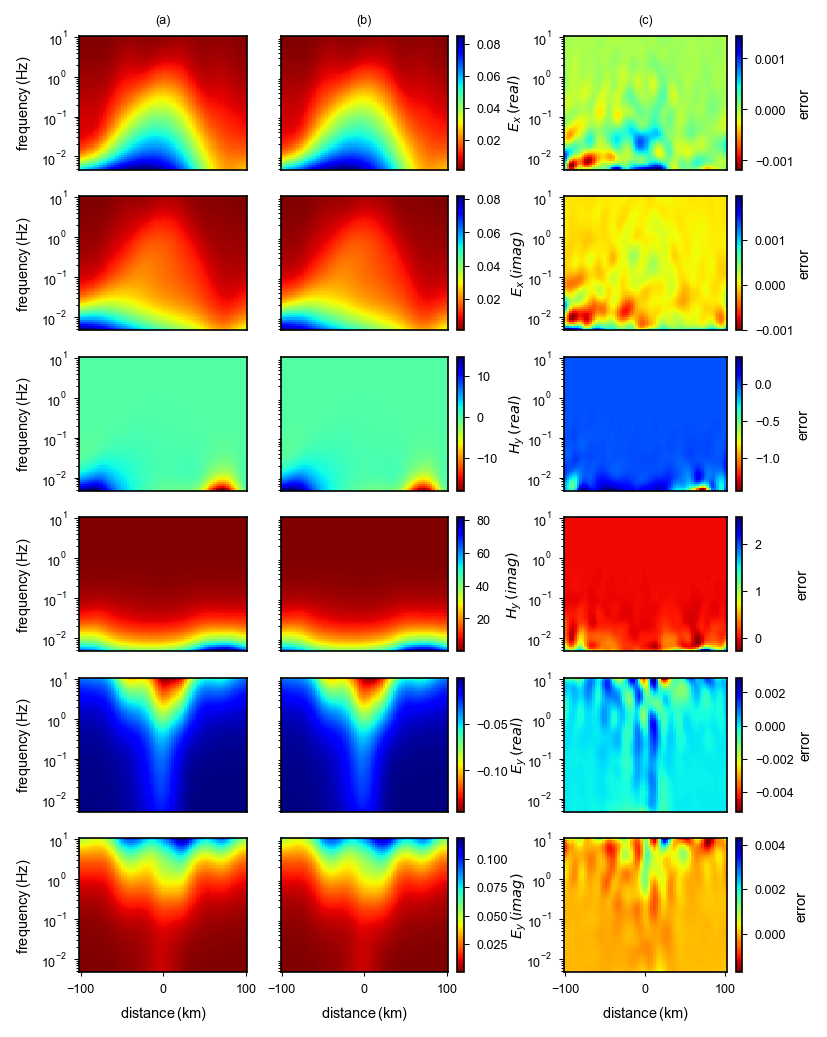

In [63]:
eps=0.00001
obs_id = 35# idx of frequency
f_id = 40# idx of frequency
id_f = 40
n_row,n_column = 6,3
figsize   = (5*n_column*cm,3.5*n_row*cm)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 6 # font size of the axes title
title_out = ['(a)','(b)','(c)']
# title_out = ['FD','transfer','relative error']

bar_label = [r'$E_x\,(real)$',r'$E_x\,(imag)$',\
             r'$H_y\,(real)$',r'$H_y\,(imag)$',
             r'$E_y\,(real)$',r'$E_y\,(imag)$']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'
Ex_real_error = Ex_real_true-Ex_real
Hy_real_error = Hy_real_true-Hy_real
Ey_real_error = Ey_real_true-Ey_real
Ex_imag_error = Ex_imag_true-Ex_imag
Hy_imag_error = Hy_imag_true-Hy_imag
Ey_imag_error = Ey_imag_true-Ey_imag
# Hx_real_error = Ex_real_true-Ex_real
data = [[Ex_real_true,Ex_real],
        [Ex_imag_true,Ex_imag],
        [Hy_real_true,Hy_real],
        [Hy_imag_true,Hy_imag],
        [Ey_real_true,Ey_real],
        [Ey_imag_true,Ey_imag],
        ]
data_error=[[Ex_real_error],#/(Ex_real_true+eps)],
            [Ex_imag_error],#/(Ex_imag_true+eps)],
            [Hy_real_error],#/(Hy_real_true+eps)],
            [Hy_imag_error],#/(Hy_imag_true+eps)],
            [Ey_real_error],#/(Ey_real_true+eps)],
            [Ey_imag_error],#/(Ey_imag_true+eps)],
             ]

norm_Ex_real = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_Ex_imag = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_Hx_real = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_Hx_imag = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm_Ey_real = colors.Normalize(vmin=np.min(data[4]),vmax=np.max(data[4]))
norm_Ey_imag = colors.Normalize(vmin=np.min(data[5]),vmax=np.max(data[5]))

norm       = [norm_Ex_real,
                norm_Ex_imag,
                norm_Hx_real,
                norm_Hx_imag,
                norm_Ey_real,
                norm_Ey_imag]

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]
ry_f        = ry_column
freq_f      = [freq[id_f],freq[id_f]]

labelpad        = [3,4,5,7,1,1] # label pad between label and bar (value is relative to axis value?)  
labelpad_error  = [2,2,8,16,2.5,4] #label pad between label and bar (value is relative to axis value?)  
pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j!=n_column-1:
            h = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
#             ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#             ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        else: 
            h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading)
            
        ax[i,j].set_yscale("log")
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0 :
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        elif j==1:# or j==2 :
            ax[i,j].set_yticks([])
        
        if j == n_column-2:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column-1)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        elif j==n_column-1:
            cbar = fig.colorbar(h,ax=ax[i,j] ,location=loc,pad=pad+0.025)
#             cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.set_label('error',fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
            
            
    ax[i,j].set_xlabel(x_label)
#         if j!=0 or i!=0:
#             ax[i,j].set_xticks([])
#             ax[i,j].set_yticks([])
# plt.subplots_adjust(wspace=0.1)
# fig.tight_layout()
# plt.savefig("../imags/E_H.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/E_H.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()

## 视电阻率和相位

In [46]:
rhoxy = out_rho[rho_id, ...,0].cpu().numpy()
rhoyx = out_rho[rho_id, ...,2].cpu().numpy()
phsxy = -1*out_rho[rho_id, ...,1].cpu().numpy()
phsyx = -1*out_rho[rho_id, ...,3].cpu().numpy()+180

rhoxy_true = out_rho_true[rho_id, ...,0].cpu().numpy()
rhoyx_true = out_rho_true[rho_id, ...,2].cpu().numpy()
phsxy_true = -1*out_rho_true[rho_id, ...,1].cpu().numpy()
phsyx_true = -1*out_rho_true[rho_id, ...,3].cpu().numpy()+180

print("Relative rhoxy,rhoyx, phsxy,phsyx error: ", \
     error_r(rhoxy,rhoxy_true),error_r(rhoyx,rhoyx_true),error_r(phsxy,phsxy_true),error_r(phsyx,phsyx_true),)

Relative rhoxy,rhoyx, phsxy,phsyx error:  0.0040472923 0.0060156872 0.0055013355 0.015781948


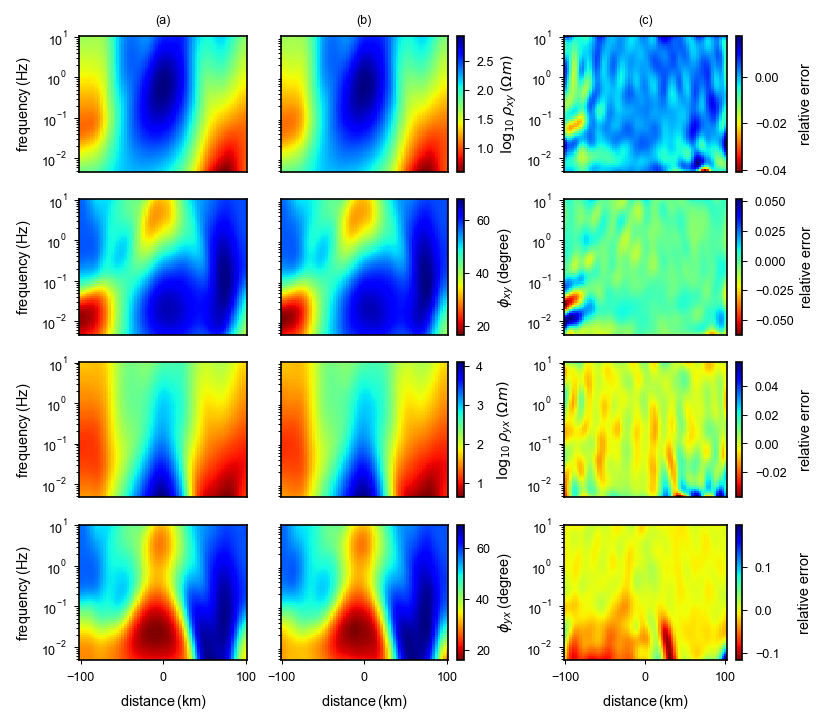

In [64]:
obs_id = 35# idx of frequency
f_id = 40# idx of frequency
id_f = 40
n_row,n_column = 4,3
figsize   = (5*n_column*cm,3.5*n_row*cm)
pad            = 0.05 # pad between colorbar and map (value is relative to figsize?)   
labelpad       = 6 # label pad between label and bar (value is relative to axis value?)  
text_size      = 7 # text size
bar_size       = 7 # label size of colorbar
# for line style
color          = 'white'
linestyle      = 'dashed'
color_f        = 'black'
linestyle_f    = 'solid'
ticks_position = 'bottom' # colorbar ticks location relative to bar
loc            = 'right' # colorbar location relative to map
text_x_pos     = -135 # text location (value is relative to axis data in map)
text_y_pos     = 18.0 
rotation       = 0  # text rotation
shading        = 'nearest' # pcolor shading, nearest for same size of x, y, C.

plt.rcParams['axes.titlesize'] = 6 # font size of the axes title
title_out = ['(a)','(b)','(c)']
# title_out = ['FD','transfer','relative error']

bar_label = [r'$\log_{10}\,\rho_{xy}\,(\Omega m)$',r'$\phi_{xy}\,$(degree)',\
             r'$\log_{10}\,\rho_{yx}\,(\Omega m)$',r'$\phi_{yx}\,$(degree)']
x_label   = r'distance$\,$(km)'
y_label   = r'frequency$\,$(Hz)'
rhoxy_error = rhoxy_true-rhoxy
phsxy_error = phsxy_true-phsxy
rhoyx_error = rhoyx_true-rhoyx
phsyx_error = phsyx_true-phsyx
data = [[rhoxy_true,rhoxy,],
        [phsxy_true,phsxy,],
        [rhoyx_true,rhoyx,],
        [phsyx_true,phsyx,]
        ]
data_error=[[rhoxy_error/rhoxy_true],
            [phsxy_error/phsxy_true],
            [rhoyx_error/rhoyx_true],
            [phsyx_error/phsyx_true]]

norm_rhoxy = colors.Normalize(vmin=np.min(data[0]),vmax=np.max(data[0]))
norm_phsxy = colors.Normalize(vmin=np.min(data[1]),vmax=np.max(data[1]))
norm_rhoyx = colors.Normalize(vmin=np.min(data[2]),vmax=np.max(data[2]))
norm_phsyx = colors.Normalize(vmin=np.min(data[3]),vmax=np.max(data[3]))
norm       = [norm_rhoxy,norm_phsxy,norm_rhoyx,norm_phsyx]

ry_row      = [ry[obs_id]/1e3,ry[obs_id]/1e3]
ry_column   = [np.min(ry)/1e3,np.max(ry)/1e3]
freq_row    = [np.min(freq),np.max(freq)]
freq_column = [freq[f_id],freq[f_id]]
ry_f        = ry_column
freq_f      = [freq[id_f],freq[id_f]]

labelpad        = [3,3,6,3] # label pad between label and bar (value is relative to axis value?)  
labelpad_error  = [6,3,6,9] #label pad between label and bar (value is relative to axis value?)  
pad            = 0.02 # pad between colorbar and map (value is relative to figsize?)   

fig,ax     = plt.subplots(n_row,n_column,figsize=figsize)
for j in range(n_column):
    for i in range(n_row):
        if j!=n_column-1:
            h = ax[i,j].pcolormesh(ry/1e3,freq,data[i][j],norm=norm[i], shading=shading)
#             ax[i,j].plot(ry_row,   freq_row,   color = color,linestyle=linestyle)
#             ax[i,j].plot(ry_column,freq_column,color = color,linestyle=linestyle)
        else: 
            h = ax[i,j].pcolormesh(ry/1e3,freq,data_error[i][0], shading=shading)
            
        ax[i,j].set_yscale("log")
        
        

        if i == 0:
            ax[i,j].set_title(title_out[j])
#             text(text_x_pos,text_y_pos,title_out[j], horizontalalignment='center',\
#                          verticalalignment='center',rotation=rotation,fontsize=text_size)
        if i!=n_row-1:
            ax[i,j].set_xticks([])
            
        if j == 0 :
            ax[i,j].yaxis.tick_left()
            ax[i,j].yaxis.set_label_position("left")
            ax[i,j].set_ylabel(y_label)
        elif j==1:
            ax[i,j].set_yticks([])
        
        if j == n_column-2:
            cbar = fig.colorbar(h,ax=[ax[i,jj] for jj in range(n_column-1)],location=loc,pad=pad)
            cbar.set_label(bar_label[i],fontsize=bar_size,labelpad=labelpad[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
        elif j==n_column-1:
            cbar = fig.colorbar(h,ax=ax[i,j] ,location=loc,pad=pad+0.025)
            cbar.set_label('relative error',fontsize=bar_size,labelpad=labelpad_error[i])
            cbar.ax.xaxis.set_ticks_position(ticks_position)
            
            
    ax[i,j].set_xlabel(x_label)
#         if j!=0 or i!=0:
#             ax[i,j].set_xticks([])
#             ax[i,j].set_yticks([])
# plt.subplots_adjust(wspace=0.1)
# fig.tight_layout()
# plt.savefig("../imags/EH_rho_phs.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/EH_rho_phs.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)

plt.show()

In [ ]:
n_bins = 5

a_cof = x_normalizer.decode(x)[i, ..., 0].cpu().numpy()
a_cof = np.log10(1/(10**a_cof))


fig = plt.figure(figsize=(8*cm,4*cm))
ax = plt.subplot(1,1,1)
h=ax.pcolormesh(yn/1e3,zn/1e3,a_cof, vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax.set_xlabel('y (km)')
ax.set_ylabel('z (km)')
ax.invert_yaxis()
cbar = fig.colorbar(h)
cbar.set_label(r"$\log_{10}\,\rho\,(\Omega m)$")# ax = plt.subplot(3,2,2)
cbar.ax.locator_params(nbins=n_bins)
# h=ax.pcolormesh(yn/1e3,zn/1e3,x_train0[i,...], shading='flat')
# ax.invert_yaxis()
# fig.colorbar(h)
# ax.set_aspect(1)
# plt.savefig("../imags/field_resisitivety.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/field_resisitivety.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()
